# EDA on manual_title

Now that we've created a manually-checked subset of the title metadata, let's do some exploratory analysis. Among other things, this can help us understand the level of error in the larger dataset.

We start by importing needed modules, and loading the data itself.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
%matplotlib inline
import seaborn as sns

In [2]:
all = pd.read_csv('manual_title_subset.tsv', sep = '\t')

### Bootstrap resampling function

We're going to want to have some quick and dirty error bars on the ratios plotted below. We can get that through bootstrap resampling.

All the error bars below will represent 90% confidence intervals.

In [3]:
def bootstrap_ratio(numtrue, numfalse):
    population = [True] * numtrue + [False] * numfalse
    results = []
    
    for i in range(1000):
        sample = np.random.choice(population, size = len(population), replace = True)
        ratio = sum(sample) / len(sample)
        results.append(ratio)
    
    results.sort()
    return results[49], results[950]
   

### Percentage of volumes that are actually fiction

One obvious question: how precise is our sample of fiction, and--even more crucially--how does the level of error vary across time?

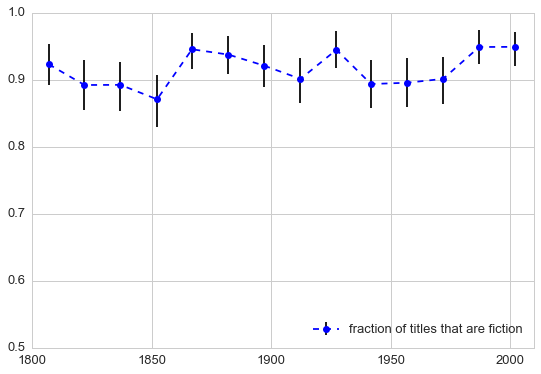

In [18]:
timeaxis = []
percentages = []
maxima = []
minima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & 
                        (all.firstpub < (decade + 15)), : ]
    ficvols = sum((in_decade.category == 'longfiction') | 
                  (in_decade.category == 'shortfiction') | 
                  (in_decade.category == 'juvenile'))
    nonficvols = sum((in_decade.category == 'notfiction')  | 
                     (in_decade.category == 'poetry') |
                    (in_decade.category == 'drama'))
    pct = ficvols / (ficvols + nonficvols)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    
    minimum, maximum = bootstrap_ratio(ficvols, nonficvols)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (9, 6))
sns.set(font_scale= 1.3)
sns.set_style("whitegrid")
plt.xlim(1800,2010)
plt.ylim(0.5, 1)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', 
             ecolor = 'k', color = 'b', label = 'fraction of titles that are fiction')
plt.legend(loc='lower right')
plt.savefig('figures/titlesubset/pctfic.png', bbox_inches = 'tight', dpi = 300)
plt.show() 


If you squint at that graph, you may suspect that accuracy increases slightly across time. There may be something to that hypothesis, but it's not statistically significant with this number of bins. *r* = .34, *p* = 0.24.

In [19]:
from scipy.stats import pearsonr
pearsonr(timeaxis, percentages)

(0.33629139929475022, 0.23975110537249483)

We could increase the number of bins, but that would also increase the size of the error bars. So, in short, it's not a particularly dramatic trend--which is good, because dramatic changes in the accuracy of our classifier could produce confounding effects when people use the titlemeta.tsv dataset to pose other questions.

### Percentage that are novels

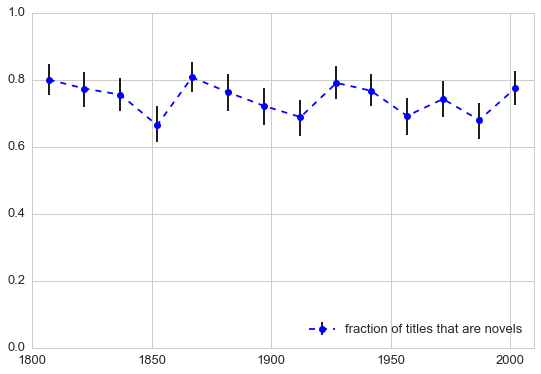

In [21]:
timeaxis = []
percentages = []
maxima = []
minima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & 
                        (all.firstpub < (decade + 15)), : ]
    categoryvols = sum((in_decade.category == 'longfiction'))
    notcatvols = sum((in_decade.category == 'notfiction')  | 
                     (in_decade.category == 'poetry') |
                    (in_decade.category == 'drama') |
                    (in_decade.category == 'shortfiction') | 
                  (in_decade.category == 'juvenile'))
    pct = categoryvols / (categoryvols + notcatvols)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    
    minimum, maximum = bootstrap_ratio(categoryvols, notcatvols)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (9, 6))
plt.xlim(1800,2010)
plt.ylim(0, 1)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', 
             ecolor = 'k', color = 'b', label = 'fraction of titles that are novels')
plt.legend(loc = 'lower right')
plt.savefig('figures/titlesubset/pctnovels.png', bbox_inches = 'tight', dpi = 300)
plt.show() 

### Percentage that are juvenile fiction

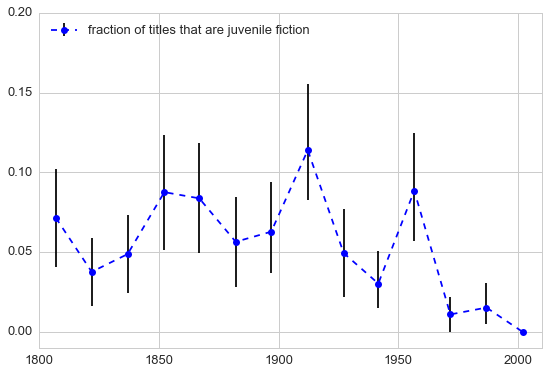

In [26]:
timeaxis = []
percentages = []
maxima = []
minima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & 
                        (all.firstpub < (decade + 15)), : ]
    categoryvols = sum((in_decade.category == 'juvenile'))
    notcatvols = sum((in_decade.category == 'notfiction')  | 
                     (in_decade.category == 'poetry') |
                    (in_decade.category == 'drama') |
                    (in_decade.category == 'shortfiction') | 
                  (in_decade.category == 'longfiction'))
    pct = categoryvols / (categoryvols + notcatvols)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    
    minimum, maximum = bootstrap_ratio(categoryvols, notcatvols)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (9, 6))
plt.xlim(1800,2010)
plt.ylim(-0.01, 0.2)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', 
             ecolor = 'k', color = 'b', label = 'fraction of titles that are juvenile fiction')
plt.legend(loc = 'upper left')
plt.savefig('figures/titlesubset/pctjuvenile.png', bbox_inches = 'tight', dpi = 300)
plt.show() 

Relative to the size of the category, these variations are very large. They could be worth keeping in mind, if you're pursuing a question where works for a juvenile audience are likely to be starkly different from other fiction, especially if you're counting exceptional works rather than calculating means. For this reason, I will provide some probabilistic guidance to help researchers filter out unmarked juvenile works in the larger fiction dataset.

Relative to the size of the overall dataset, the variation is not huge; we'll see later how much difference it makes to some typical diachronic questions. But it is notable that accuracy improves in the last couple of decades, probably because genre was actually **recorded** in the last thirty years, improving my ability to filter out juvenile works.

### Accuracy of estimated dates

Another source of error in our larger dataset is that volumes are not dated to the date of first publication. The best I can do is something I call ```latestcomp```--latest possible date of composition, which is basically an intersection of earliest attested publication date for the title, and author's death date.

How much error does this cause? Let's look at the percentage of books where ```latestcomp``` is more than ten years after true ```firstpub```.


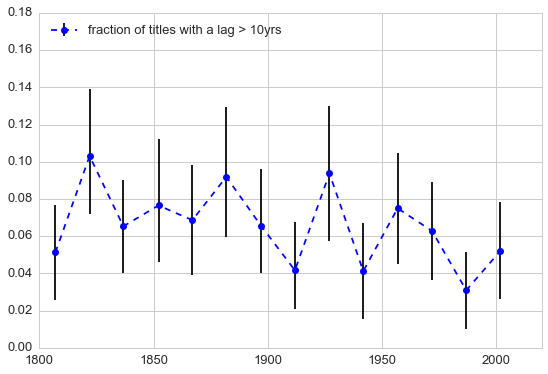

In [30]:
timeaxis = []
percentages = []
maxima = []
minima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.latestcomp >= decade) & 
                        (all.latestcomp < (decade + 15)), : ]
    
    timeaxis.append(np.mean(in_decade.latestcomp))
    diffs = np.absolute(in_decade.latestcomp - in_decade.firstpub)
    misdated = sum(diffs > 10)
    notmisdated = len(diffs) - misdated
    percentages.append(misdated / (misdated + notmisdated))
    minimum, maximum = bootstrap_ratio(misdated, notmisdated)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (9, 6))
plt.xlim(1800,2020)
plt.ylim(0,0.18)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', 
             ecolor = 'k', color = 'b', label = 'fraction of titles with a lag > 10yrs')
plt.legend(loc = 'upper left')
plt.savefig('figures/titlesubset/offby10.png', bbox_inches = 'tight', dpi = 300)
plt.show() 

Basically, there is at all times a moderate-sized (4-10%) chunk of the collection where ```latestcomp``` significantly misses date of first publication. Once again, accuracy may improve in the last thirty years or so, but there is no statistically significant trend.

Of course, this is just reporting the fraction of volumes where there is any error greater than 10 years. The actual size of the error can vary hugely, covering everything from off-by-11-year novels to medieval sagas, or Plutarch! We could calculate the "mean error" or "median error," but those tell us very little. The median error is always zero. The mean error varies greatly but the variation is driven entirely by outliers. This may be more useful:


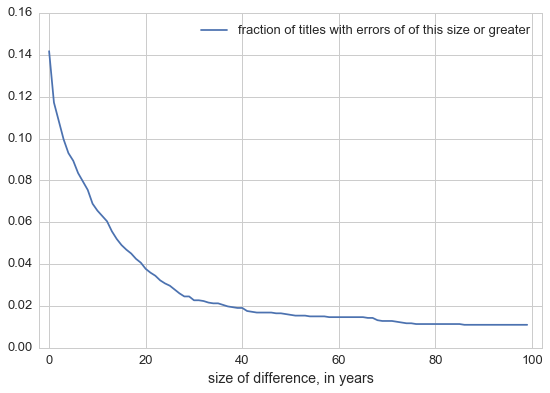

In [33]:
diffs = all.latestcomp - all.firstpub
sizes = []
ratios = []

for errorsize in range(100):
    errorcount = sum(diffs > errorsize)
    sizes.append(errorsize)
    ratios.append(errorcount / len(diffs))

plt.figure(figsize = (9, 6))
plt.plot(sizes, ratios, label = 'fraction of titles with errors of of this size or greater')
plt.xlabel('size of difference, in years')
plt.xlim(-2, 102)
plt.legend(loc = 'upper right')
plt.savefig('figures/titlesubset/errorcurve.png', bbox_inches = 'tight', dpi = 300)
plt.show()
    

In [10]:
def isfiction(astring):
    ''' Note that this doesn't count juvenile fiction.
    '''
    
    if pd.isnull(astring):
        return 'not'

    if 'longfiction' in astring or 'shortfiction' in astring:
            return 'fic'
    else:
        return 'not'

all = all.assign(isfic = all.category.map(isfiction))

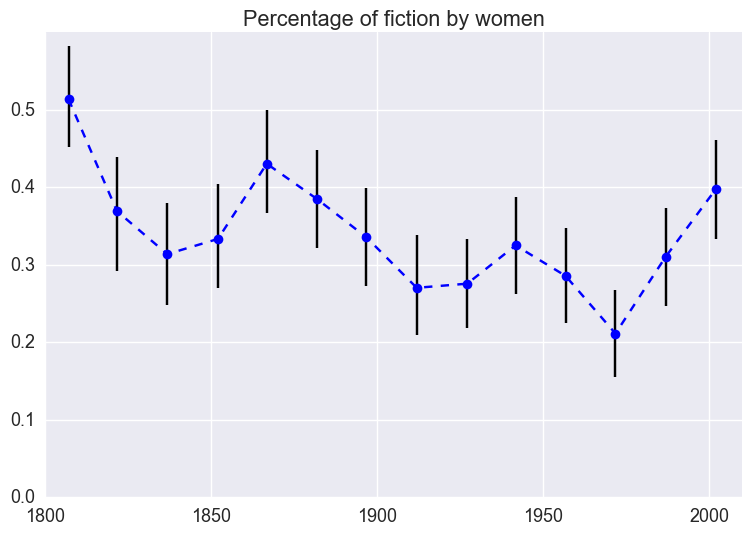

In [34]:
timeaxis = []
percentages = []
minima = []
maxima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & (all.firstpub < (decade + 15)) & ((all.isfic == 'fic')), : ]
    masculine = sum(in_decade.gender == 'm') 
    feminine = sum(in_decade.gender == 'f')
    pct = feminine / (masculine + feminine)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    minimum, maximum = bootstrap_ratio(feminine, masculine)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (9, 6))
plt.xlim(1800,2010)
plt.ylim(0.0, 0.6)
plt.title('Percentage of fiction by women')
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', ecolor = 'k', color = 'b')
# plt.savefig('figures/titlesubset/pctwomen.png')
plt.show() 


In [35]:
weighted = pd.read_csv('weighted_subset.tsv', sep = '\t')
weighted = weighted.assign(isfic = weighted.category.map(isfiction))

In [36]:
weighttimes = []
weightpcts = []

for decade in range(1800, 2010, 15):
    in_decade = weighted.loc[(weighted.firstpub >= decade) & (weighted.firstpub < (decade + 15)) & ((weighted.isfic == 'fic')), : ]
    masculine = sum(in_decade.gender == 'm') 
    feminine = sum(in_decade.gender == 'f')
    pct = feminine / (masculine + feminine)
    weighttimes.append(np.mean(in_decade.firstpub))
    weightpcts.append(pct)

In [41]:
usuk = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & (all.firstpub < (decade + 15)) &
                        (all.isfic == 'fic') &
                        ((all.nationality == 'uk') | (all.nationality == 'us')), : ]
    masculine = sum(in_decade.gender == 'm') 
    feminine = sum(in_decade.gender == 'f')
    pct = feminine / (masculine + feminine)
    usuk.append(pct)

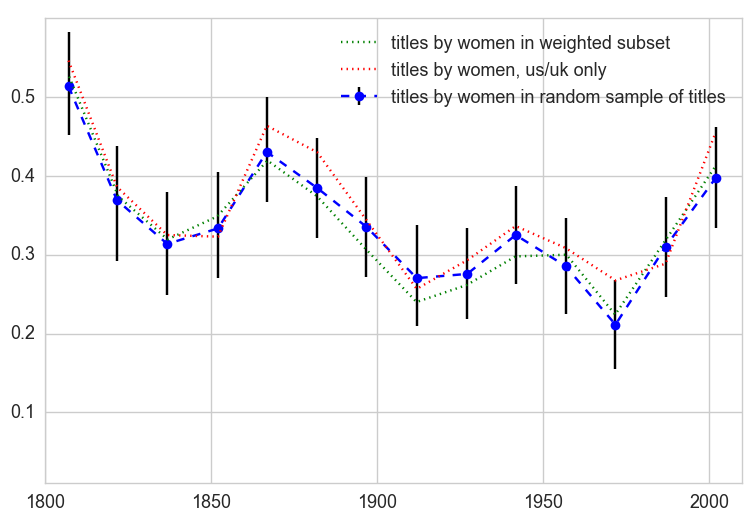

In [45]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize = (9, 6))
plt.xlim(1800,2010)
plt.ylim(0.01, 0.6)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o', 
             ecolor = 'k', color = 'b', label = 'titles by women in random sample of titles')
plt.plot(weighttimes, weightpcts, 'g:', label = 'titles by women in weighted subset')
plt.plot(timeaxis, usuk, 'r:', label = 'titles by women, us/uk only')
plt.legend(loc='upper right')
plt.savefig('figures/titlesubset/pctwomentwodatasets.png', bbox_inches = 'tight', dpi = 400)
plt.show()

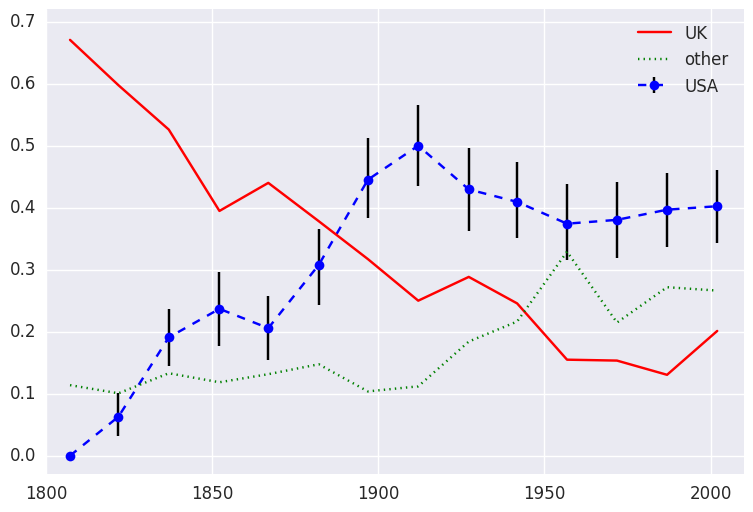

In [33]:
timeline = []
usa = []
uk = []
other = []
minima = []
maxima = []


for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & (all.firstpub < (decade + 15)) & ((all.isfic == 'fic')), : ]
    numvols = len(in_decade)
    usexamples = sum(in_decade.nationality == 'us') 
    ukexamples = sum(in_decade.nationality == 'uk')
    unknown = sum(pd.isnull(in_decade.nationality))
    otherex = numvols - (usexamples + ukexamples + unknown)
    usa.append(usexamples / numvols)
    uk.append(ukexamples / numvols)
    other.append(otherex / numvols)
    minimum, maximum = bootstrap_ratio(usexamples, (numvols - usexamples))
    minima.append(minimum)
    maxima.append(maximum)
    timeline.append(np.mean(in_decade.firstpub))

downward = np.array(usa) - np.array(minima)
upward = np.array(maxima) - np.array(usa)
plt.figure(figsize = (9, 6))
plt.xlim(1800,2010)
plt.ylim(-0.03, 0.72)
plt.errorbar(timeline, usa, yerr = [downward, upward], fmt='--o', ecolor = 'k', color = 'b', label = "USA")
plt.plot(timeline, uk, color = 'r', label = "UK")
plt.plot(timeline, other, 'g:', label = 'other')
plt.legend(loc='upper right')
sns.set(font_scale= 1.3)
plt.savefig('figures/titlesubset/pctusa.png', dpi = 400, bbox_inches = 'tight')
plt.show()